# Visualizing GSD File

In this example, we will use `fresnel` to visualize a gsd file. We will color the particles & bonds by types, as well as visualize the simulation box.

We will need the [gsd](https://gsd.readthedocs.io/en/stable/) and [freud](https://freud.readthedocs.io/en/stable/index.html) package to run this example.

In [1]:
import freud
import fresnel
import gsd.hoomd
import numpy as np

scipy.spatial.Voronoi is not available (requires scipy 0.12+), so freud.voronoi is not available.
scipy.spatial.Voronoi is not available (requires scipy 0.12+), so freud.voronoi is not available.


First we read in the `.gsd` file, then we unwrap the particle positions so the bonds are not stretched across the periodic boundary

In [2]:
with gsd.hoomd.open(name="molecules.gsd", mode="rb") as gsd_file:
    snap = gsd_file[0]

box = freud.box.Box.from_box(snap.configuration.box)
images = snap.particles.image
# Freud modifies positions in place, but we will use unwrapped_coords to be explicit 
unwrapped_coords = box.unwrap(snap.particles.position, images)

We want to color by particle type. We will color A types red, B types blue, and C types green.

In [3]:
N = snap.particles.N
particle_types = snap.particles.typeid
colors = np.empty((N, 3))
# Color by typeid
colors[particle_types == 0] = fresnel.color.linear([.95, 0, 0]) # A type
colors[particle_types == 1] = fresnel.color.linear([0, .95, 0]) # B type
colors[particle_types == 2] = fresnel.color.linear([0, 0, .95]) # C type

In [4]:
scene = fresnel.Scene()

# Spheres for every particle in the system
geometry = fresnel.geometry.Sphere(scene, N=N, radius=0.2)
geometry.position[:] = unwrapped_coords
geometry.material = fresnel.material.Material(roughness=0.5)
# use color instead of material.color
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)

In [5]:
# use freud box to create box in fresnel
fresnel.geometry.Box(scene, box, radius=.1)

We will visualize bonds using cylinders, and color the bonds to match the particle types.

In [6]:
N_bonds = snap.bonds.group.shape[0]
bonds = fresnel.geometry.Cylinder(scene, N=N_bonds)

# Color by bond typeid
bond_ids = snap.bonds.typeid
bond_colors = np.empty((N_bonds, 3))
bond_colors[bond_ids == 0] = fresnel.color.linear([0, .95, 0])  # B-B Bonds
bond_colors[bond_ids == 1] = fresnel.color.linear([0, 0, .95])  # C-C Bonds

bonds.material.primitive_color_mix = 1.0
bonds.points[:] = np.stack(
    [
        snap.particles.position[snap.bonds.group[:, 0]],
        snap.particles.position[snap.bonds.group[:, 1]],
    ],
    axis=1,
)


bonds.color[:] = np.stack(
    [fresnel.color.linear(bond_colors), fresnel.color.linear(bond_colors)], axis=1
)
bonds.radius[:] = [0.1] * N_bonds

Now that we have everything setup, we will render everything and apply some TODO lighting conditions.

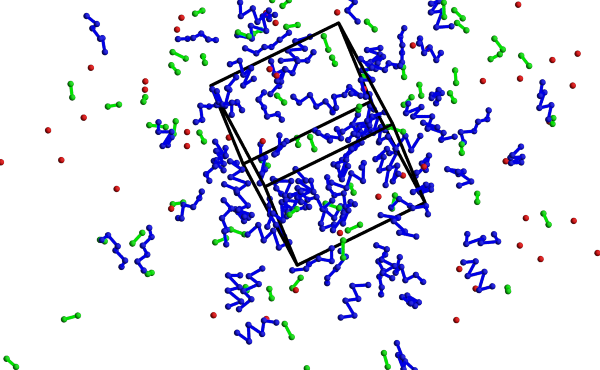

In [7]:
scene.camera = fresnel.camera.orthographic(
    position=(30.3060245513916, 37.956146240234375, 4.508306980133057),
    look_at=(-8.020124435424805, -13.921954154968262, 1.3848066329956055),
    up=(-0.7095521688461304, 0.550669252872467, -0.439657986164093),
    height=23.36834716796875,
)
fresnel.preview(scene, aa_level=3)